In [1]:
import pandas as pd 
import os
from IPython.display import display,Audio
import cv2
import matplotlib.pyplot as plt
import librosa
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchaudio
from sklearn import preprocessing

# Load the trained model

In [2]:
class NN2DMEL(nn.Module):
    def __init__(self, num_class):
        super(NN2DMEL,self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=8,kernel_size=3,stride=1)
        self.dropout1 = nn.Dropout(0.3) 
    
        self.conv2 = nn.Conv2d(in_channels=8,out_channels=16,kernel_size=3,stride=1)
        self.dropout2 = nn.Dropout(0.3)
        
        self.fc1 = nn.Linear(768, 256)
        self.dropout5 = nn.Dropout(0.3)
        
        self.fc2 = nn.Linear(256,128)
        self.dropout6 = nn.Dropout(0.3)
        
        self.fc3 = nn.Linear(128, num_class)
        
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)),kernel_size=3)
        x = self.dropout1(x)
        x = F.max_pool2d(F.relu(self.conv2(x)),kernel_size=3)
        x = self.dropout2(x)
        x = F.relu(self.fc1(x.reshape(-1,x.shape[1] * x.shape[2]*x.shape[3])))
        x = self.dropout5(x)
        
        x = F.relu(self.fc2(x))
        x = self.dropout6(x)
        
        x = self.fc3(x)
        
        #print(x.shape)
        return x 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

net = NN2DMEL(num_class=6)

net = net.to(device)

state_model_dict =  torch.load(
    '/kaggle/input/speech-command-reognition-model-mel-spec/epoch_194.pth',
    map_location=torch.device('cpu')
)

net.load_state_dict(state_model_dict)

net.eval()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(),lr=0.001)

# Create Input tensor

In [3]:
class TextProcessed:
    def __init__(self,characters = None,commands = None):
        if characters != None:
            #For transcription recognize
            self.characters = characters
            self.characters_map = dict()
            self.index_characters_map = dict()
            for i, character in enumerate(self.characters):
                self.characters_map[character] = i
                self.index_characters_map[i] = character
        if commands != None:
            #for classification
            self.commands = commands
            self.commands_dict = dict()
            self.index_commands_dict = dict()
            for i, command in enumerate(self.commands):
                self.commands_dict[command] = i
                self.index_commands_dict[i] = command
                
    def text2int(self, text):
        int_list = list()
        for ch in text:
            int_list.append(self.characters_map[ch])
        return int_list
    
    def int2text(self, int_list):
        ch_list = list()
        for int_ch in int_list:
            ch_list.append(self.index_characters_map[int_ch])
        return ''.join(ch_list)
    
commands_list = ['go','stop','forward','down','left','right']
tp = TextProcessed(commands = commands_list)

In [4]:
def melTransform(waveform,sample_rate):
    transform = torchaudio.transforms.MelSpectrogram(sample_rate=sample_rate, n_mels=64)
    return transform(waveform)

def mfccTransform(waveform,sample_rate):
    transform = torchaudio.transforms.MFCC(sample_rate=sample_rate, n_mfcc=64,)
    return transform(waveform)

def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch
    #return batch.permute(0, 2, 1)

def collate_fn(batch):

    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number

    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, sample_rate, label in batch:
        #print(melTransform(waveform,sample_rate).shape)
        tensors += [melTransform(waveform,sample_rate)[0]]
        targets += [label]
    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    tensors = tensors.permute([0,2,1])
    new_dim_tensor = []
    for tensor in tensors:
        #print(torch.unsqueeze(tensor, dim=0).shape)
    #    print(tensor.permute([1,81,64]).shape)
        new_dim_tensor += [torch.unsqueeze(tensor, dim=0)]
    #print(torch.Tensor(new_dim_tensor).shape)
    new_tensor = torch.stack(new_dim_tensor)
    targets = torch.Tensor(targets)

    return new_tensor, targets

def collate_fn_pred(tuple_):
        # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number

    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    waveform, sample_rate, label = tuple_
    #print(melTransform(waveform,sample_rate).shape)
    tensors += [melTransform(waveform,sample_rate)[0]]
    targets += [label]
    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    tensors = tensors.permute([0,2,1])
    new_dim_tensor = []
    for tensor in tensors:
        #print(torch.unsqueeze(tensor, dim=0).shape)
    #    print(tensor.permute([1,81,64]).shape)
        new_dim_tensor += [torch.unsqueeze(tensor, dim=0)]
    #print(torch.Tensor(new_dim_tensor).shape)
    new_tensor = torch.stack(new_dim_tensor)
    targets = torch.Tensor(targets)

    return new_tensor, targets

def plot_waveform(waveform, sr, title="Waveform"):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sr

    figure, axes = plt.subplots(num_channels, 1)
    axes.plot(time_axis, waveform[0], linewidth=1)
    axes.grid(True)
    figure.suptitle(title)
    plt.show(block=False)
    
def plot_spectrogram(specgram, title=None, ylabel="freq_bin"):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto")
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

### and check input tensors

In [5]:
waveform, sample_rate = torchaudio.load('/kaggle/input/audio-command-sample/sample.wav')

In [6]:
Audio(waveform, rate=sample_rate)

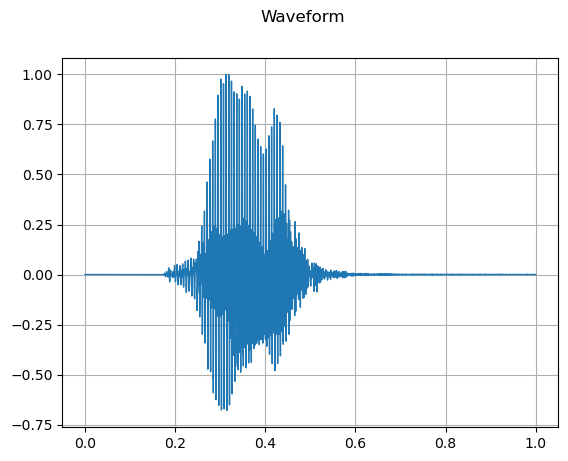

torch.Size([1, 16000])

In [7]:
plot_waveform(waveform,sample_rate)
waveform.shape

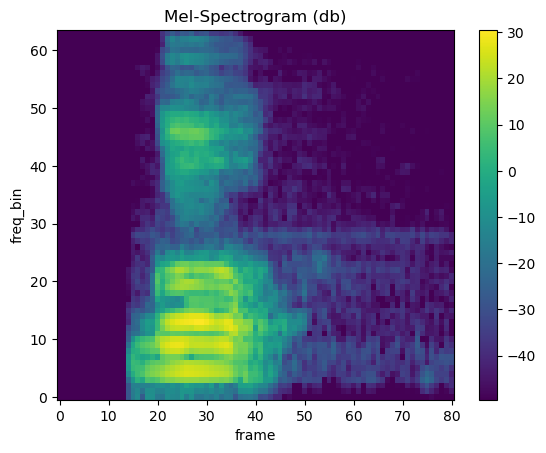

torch.Size([1, 64, 81])

In [8]:
plot_spectrogram(melTransform(waveform,sample_rate)[0],title='Mel-Spectrogram (db)')
melTransform(waveform,sample_rate).shape

/opt/conda/lib/python3.7/site-packages/torchaudio/functional/functional.py:572: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  "At least one mel filterbank has all zero values. "


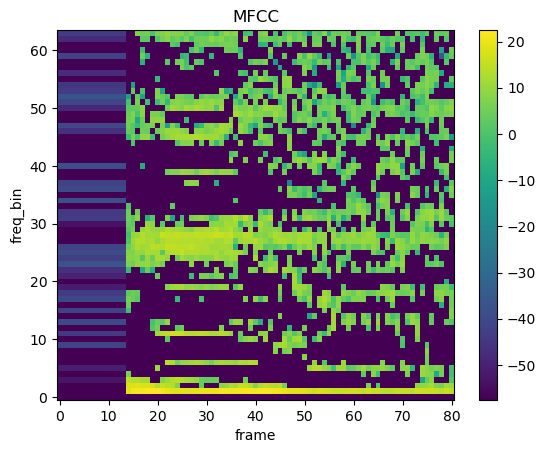

torch.Size([1, 64, 81])

In [9]:
plot_spectrogram(mfccTransform(waveform,sample_rate)[0],title='MFCC')
mfccTransform(waveform,sample_rate).shape

In [13]:
mel_transform  = torchaudio.transforms.MelSpectrogram(sample_rate=16000, n_mels=64)
mel_waveform = mel_transform(waveform)

input_tensor =  mel_waveform[None,None,:,:]
#input_tensor = collate_fn_pred((mel_waveform,sample_rate,label))
print(input_tensor[0].shape)

torch.Size([1, 1, 64, 81])


# Get output tensor

In [14]:
output_tensor = net(input_tensor[0])

# Decode output tensor

In [15]:
print('Prediction :')
tp.index_commands_dict[int(torch.max(output_tensor.data, 1).indices)]

Prediction :


'go'